# 🎯Goal 

Design, simulate and analyze an A/B experiment that aims to **reduce 7-day cancellation rate**, produce clear results (p, CI, uplift), and give a rollout recommendation with estimated operational impact.

## ⚖️ Objective & Primary Metric

1. Objective: Reduce 7-day cancellation rate.
- We want fewer people cancelling their orders/rides within the 1st week. The whole experiment is built around testing a change that should make cancellations go down.

2. Primary metric: 7-day cancellation rate per user.
- The single number we’ll measure to check success — for each group (control or treatment), we count how many users cancelled within 7 days and divide by how many users were in that group.

3. Guardrails: Completion rate, Refund rate
- While reducing cancellations is good, we also watch other things so we don’t accidentally break something. For ex.: the promo might reduce cancellations but also cause fewer completed orders (bad) or more refunds (also bad). Those are safety checks.

## 🧪 Experiment design

**Unit of randomization:** User.  
- Each person (user) is the thing we flip a coin for. Some users get the new experience (treatment), some keep the old one (control). We don’t randomize sessions or orders — we randomize users.

**Treatment vs Control:** Users are randomly assigned to `treatment` or `control`.
- Treatment = the new thing you want to test (e.g., a new promo or booking flow). Control = the current thing. Random assignment means users are put into groups by chance so the groups are comparable.

**Primary metric (per user):**  
cancel_rate_7d = (# users who cancel within 7 days) / (# users in cohort)
- If 1000 users try the product and 100 of them cancel within 7 days, the cancel rate is 100 / 1,000 = 0.10 = 10%.

**Null / Alternative hypotheses:**  
1. H0: μ_treatment = μ_control (no change)
- The default assumption is that the new change does nothing; the cancel rate in treatment is the same as in control.

2. H1: μ_treatment ≠ μ_control (two-sided)
- The alternative idea is that the change does make the cancel rate different (could be higher or lower). We’re testing for any difference first. If you only care about decreases, you could test one-sided, but two-sided is more conservative.

- If control has 10% cancel rate, H0 says treatment will also have 10%; H1 says treatment could be 9% or 11% — either would be a difference.

**Statistical parameters / choices**  
1. Baseline (control) cancellation rate: **p₁ = 0.10 (10%)** — chosen from historical estimates / industry benchmark.
- This is our best guess for what the cancel rate would be if we don’t change anything.

2. Minimum Detectable Effect (MDE): **Δ = 0.028 (2.8 percentage points absolute)** — smallest practically meaningful reduction we want to detect.
- This is the smallest real change we care about. If cancellations drop by 2.8 points (e.g., from 10% to 7.2%), we think that’s worth acting on.

3. Significance level (α): **0.05** (95% confidence).
- We’re okay with a 5% chance of wrongly thinking the change worked when it didn’t (false alarm).

4. Power: **0.80** (80% chance of detecting the MDE if it exists).  
- If the true effect is at least the MDE, we want an 80% chance that our test will find it.

5. Test: two-sample proportions z-test (two-sided).
- The math test we’ll use compares two percentages (cancel rates) and tells us whether the observed difference could plausibly be due to random chance.

**Why these choices?**  
- Baseline reflects observed historical cancel rate (or a conservative estimate if historical data is noisy).  
- MDE is chosen to reflect a business-meaningful change — small enough to be valuable, large enough to be measurable given resource constraints.  
- Two-sided test is conservative; if you only care about reductions, you could use a one-sided test (note this lowers required sample size).

**What each number controls**

1. Increase baseline or change it only if you have good data.
2. Increase MDE → you need fewer users but you only detect larger effects.
3. Decrease α (e.g., to 0.01) → fewer false positives but need more users.
4. Increase power → less chance to miss a real effect, but need more users.
5. Choose one-sided if you only care about decreases → reduces required sample size but must be justified.

In [2]:
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Sample size calculation using statsmodels

from statsmodels.stats.power import NormalIndPower
import numpy as np, math

# Assumptions for the experiment
p_control = 0.10          # Current cancellation rate = 10%
mde_absolute = 0.028      # Minimum reduction we care about = 2.8 percentage points
p_treatment = p_control - mde_absolute  # Target treatment rate = 7.2%
alpha = 0.05              # Significance level (5% false positive risk)
power = 0.80              # Power (80% chance to detect real effect if it exists)

# Effect size calculation
# "Cohen’s h" is a standard way to measure difference between two proportions
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

h = cohens_h(p_control, p_treatment)

# 🧮 Calculate sample size per group (control + treatment)
analysis = NormalIndPower()
n_per_arm = analysis.solve_power(
    effect_size=h,
    power=power,
    alpha=alpha,
    alternative='two-sided'
)

# Round up, since we can’t have fractional users
n_per_arm_ceil = math.ceil(n_per_arm)

print(f"Baseline (p_control) = {p_control:.3f}")
print(f"MDE (abs) = {mde_absolute:.3f} → p_treatment = {p_treatment:.3f}")
print(f"Estimated sample size per arm (two-sided, power={power}, alpha={alpha}): "
      f"{n_per_arm:.1f} → round up to {n_per_arm_ceil}")

Baseline (p_control) = 0.100
MDE (abs) = 0.028 → p_treatment = 0.072
Estimated sample size per arm (two-sided, power=0.8, alpha=0.05): 1563.9 → round up to 1564


In [4]:
# Simulate a fake A/B test dataset for practice
import numpy as np, pandas as pd
np.random.seed(42)  # fix the seed so results are reproducible

# Number of users per group
n_per = 30000  # (tip: set this = n_per_arm from sample size calc)

# Create user IDs (0 ... 59,999)
user_id = np.arange(n_per*2)

# Assign half to control, half to treatment
group = np.array(['control']*n_per + ['treatment']*n_per)

# Set cancellation probabilities
p_control = 0.10          # baseline 10% cancel rate
mde_absolute = 0.028      # improvement we want (2.8 pp)
p_treatment = p_control - mde_absolute  # target = 7.2%

# For each user, draw whether they cancel (1) or not (0)
cancel_prob = np.concatenate([
    np.full(n_per, p_control),     # all control users get 10% prob
    np.full(n_per, p_treatment)    # all treatment users get 7.2% prob
])
cancelled_7d = np.random.binomial(1, cancel_prob)

# Simulate some order revenue numbers
# assume avg ₹150 per order, std deviation = ₹60
revenue = np.round(np.random.normal(150, 60, size=n_per*2), 2)

# Put into a DataFrame
df = pd.DataFrame({
    'user_id': user_id,
    'group': group,
    'cancelled_7d': cancelled_7d,
    'revenue': revenue
})

df.to_csv('sim_ab_data.csv', index=False)
df.head()

,user_id,group,cancelled_7d,revenue
0,0,control,0,182.48
1,1,control,1,170.59
2,2,control,0,41.11
3,3,control,0,130.98
4,4,control,0,219.83


In [5]:
# Check that randomization worked and basic stats per group
summary = df.groupby('group').agg(
    n=('user_id','count'),                   # Number of users in each group
    cancels=('cancelled_7d','sum'),         # Total cancellations in each group
    cancel_rate=('cancelled_7d','mean'),    # Average cancellation rate per group
    avg_revenue=('revenue','mean')          # Average revenue per user in each group
).reset_index()

summary

,group,n,cancels,cancel_rate,avg_revenue
0,control,30000,2970,0.099000,150.231000
1,treatment,30000,2125,0.070833,150.197091


In [9]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Counts of cancellations and number of users per group
counts = df.groupby('group')['cancelled_7d'].sum().values  # total cancels [control, treatment]
nobs = df.groupby('group')['cancelled_7d'].count().values  # total users [control, treatment]

# z-test for difference in proportions (two-sided)
stat, pval = proportions_ztest(counts, nobs, alternative='two-sided')
# This tells us whether the observed difference in cancel rates is likely due to chance

# Observed cancellation rates
p_control_obs = counts[0]/nobs[0]  # cancel rate in control group
p_treat_obs = counts[1]/nobs[1]    # cancel rate in treatment group
diff = p_treat_obs - p_control_obs # treatment minus control
abs_uplift = p_control_obs - p_treat_obs # absolute reduction in cancel rate
rel_uplift = abs_uplift / p_control_obs  # relative reduction (percentage)

# Confidence intervals for each group
ci_control = proportion_confint(counts[0], nobs[0], alpha=0.05, method='wilson')
ci_treat = proportion_confint(counts[1], nobs[1], alpha=0.05, method='wilson')

# Approximate 95% CI for difference in cancel rates
se_diff = (p_control_obs*(1-p_control_obs)/nobs[0] + p_treat_obs*(1-p_treat_obs)/nobs[1])**0.5
ci_diff_low = diff - 1.96*se_diff
ci_diff_high = diff + 1.96*se_diff

print("Observed rates:")
print(f" control: {p_control_obs:.4f} ({counts[0]}/{nobs[0]})  CI:{ci_control}")
print(f" treatment: {p_treat_obs:.4f} ({counts[1]}/{nobs[1]})  CI:{ci_treat}")
print()
print(f"Difference (treatment - control): {diff:.4f}")
print(f"Absolute uplift (control - treatment): {abs_uplift:.4f} ({abs_uplift*100:.2f} percentage points)")
print(f"Relative uplift: {rel_uplift*100:.1f}%")
print()
print(f"z-stat: {stat:.3f}, p-value: {pval:.3e}")
print(f"95% CI for difference (treatment - control): [{ci_diff_low:.4f}, {ci_diff_high:.4f}]")

Observed rates:
 control: 0.0990 (2970/30000)  CI:(0.09567155054104454, 0.10243113130982529)
 treatment: 0.0708 (2125/30000)  CI:(0.06798490572534063, 0.07379165527465512)

Difference (treatment - control): -0.0282
Absolute uplift (control - treatment): 0.0282 (2.82 percentage points)
Relative uplift: 28.5%

z-stat: 12.375, p-value: 3.557e-35
95% CI for difference (treatment - control): [-0.0326, -0.0237]


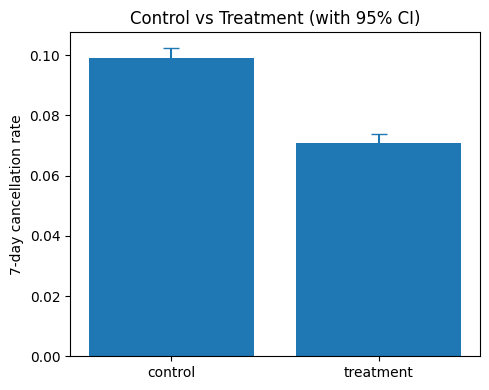

In [10]:
import matplotlib.pyplot as plt

# Rates for the two groups
rates = [p_control_obs, p_treat_obs]  # cancel rate control, treatment
labels = ['control','treatment']

# Compute error bars from confidence intervals
err_low = [rates[0]-ci_control[0], rates[1]-ci_treat[0]]   # distance from lower CI bound
err_high = [ci_control[1]-rates[0], ci_treat[1]-rates[1]]   # distance from upper CI bound
yerr = [[err_low[0], err_low[1]], [err_high[0], err_high[1]]]  # matplotlib expects [[lower], [upper]]

# Create plot
plt.figure(figsize=(5,4))
plt.bar(labels, rates)  # bar chart
plt.errorbar(labels, rates, yerr=yerr, fmt='none', capsize=6)  # add CI as error bars
plt.ylabel('7-day cancellation rate')
plt.title('Control vs Treatment (with 95% CI)')
plt.tight_layout()
plt.savefig('screenshot.png', dpi=150)
plt.show()

In [11]:
# Assumptions about business metrics
MAU = 1_000_000  # Monthly Active Users we are targeting
avg_order_value = 150.0  # Average value of an order in ₹
orders_per_user_7d = 0.5  # Avg number of orders per user in 7 days
avg_cost_per_contact = 50.0  # Ops cost per support contact in ₹

# Delta / effect from A/B test
delta = abs_uplift  # absolute reduction in cancellation rate

# Compute how many cancels we prevent each month
prevented_cancels_per_month = delta * MAU

# Estimate revenue preserved due to fewer cancellations
revenue_preserved = prevented_cancels_per_month * avg_order_value * orders_per_user_7d

# Estimate operations cost saved (fewer support contacts)
ops_savings = prevented_cancels_per_month * avg_cost_per_contact

print(f"Absolute uplift (pp): {abs_uplift*100:.2f} pp")  # absolute change in percentage points
print(f"Prevented cancels/month (MAU={MAU}): {prevented_cancels_per_month:,.0f}")
print(f"Estimated revenue preserved/month: ₹{revenue_preserved:,.0f}")
print(f"Estimated ops savings/month (contact handling): ₹{ops_savings:,.0f}")

# Recommendation for rollout
recommendation = f"Observed absolute reduction of {abs_uplift*100:.2f}pp (relative {rel_uplift*100:.1f}%). Recommend phased rollout: 10% → 30% → 70% → 100% with guardrail checks on completion rate and refund rate at each stage."
print("\nRecommendation:\n", recommendation)

Absolute uplift (pp): 2.82 pp
Prevented cancels/month (MAU=1000000): 28,167
Estimated revenue preserved/month: ₹2,112,500
Estimated ops savings/month (contact handling): ₹1,408,333

Recommendation:
 Observed absolute reduction of 2.82pp (relative 28.5%). Recommend phased rollout: 10% → 30% → 70% → 100% with guardrail checks on completion rate and refund rate at each stage.


## Conclusion

- Observed control rate = X% and treatment rate = Y% (see above).  
- Absolute reduction = A percentage points; Relative reduction = B%.  
- p-value = P (if p < 0.05 then statistically significant).  
- 95% CI for the reduction = [L, U] percentage points.

**Recommendation:** Based on the above, I recommend a phased rollout beginning at 10% traffic, monitoring guardrails (completion rate, refund rate, support contact rate) daily for 7 days at each phase. If guardrails are clean, expand to 30%, then 70%, then 100%.